---

<a href="https://github.com/rraadd88/roux/blob/master/examples/roux_lib_df.ipynb"><img align="right" style="float:right;" src="https://img.shields.io/badge/-source-cccccc?style=flat-square"></a>

## ⌗ Dataframes.

**Optional requirements**

In [1]:
# to show logging messages
import logging
logging.getLogger().setLevel(logging.INFO)
## to create dfs for testing
import pandas as pd

## Import `r`oux-`d`ataframe attributes

In [2]:
import roux.lib.dfs as rd #noqa

## Basic data checks 

**Demo data**

In [3]:
import seaborn as sns
import numpy as np
data=sns.load_dataset('iris')
data=(
    data
    .assign(
    **{
        ## insert missing values 
        "sepal_length with missing values":lambda df: df['sepal_length'].apply(lambda x: np.nan if x>5 else x),
        'species id': lambda df: df.groupby('species')['species'].transform(lambda x: [f"item{i:02d}" for i in range(len(x))])
    }
    )
)
data.head(1)

,sepal_length,sepal_width,petal_length,petal_width,species,sepal_length with missing values,species id
0,5.1,3.5,1.4,0.2,setosa,NaN,item00


### Missing values 

Check the counts

In [4]:
data.rd.check_na(subset=['sepal_length with missing values'],perc=True) # returns counts

sepal_length with missing values    78.666667
dtype: float64

.. in chained operations

In [5]:
(data
    .rd.check_na(subset=['sepal_length with missing values'],out=False) # returns the original dataframe
    .head(1) 
)

INFO:root:sepal_length with missing values = 118


,sepal_length,sepal_width,petal_length,petal_width,species,sepal_length with missing values,species id
0,5.1,3.5,1.4,0.2,setosa,NaN,item00


### Duplicates

Check duplicate rows

In [6]:
data.rd.check_dups(subset='sepal_length').head() # returns duplicate rows

INFO:root:duplicate rows: 94.0% (141/150)


,sepal_length,sepal_width,petal_length,petal_width,species,sepal_length with missing values,species id
8,4.4,2.9,1.4,0.2,setosa,4.4,item08
38,4.4,3.0,1.3,0.2,setosa,4.4,item38
42,4.4,3.2,1.3,0.2,setosa,4.4,item42
3,4.6,3.1,1.5,0.2,setosa,4.6,item03
6,4.6,3.4,1.4,0.3,setosa,4.6,item06


Check counts in chained operations

In [7]:
(data
    .rd.check_dups(subset='sepal_length',out=False) # returns the original dataframe
    .head()
)

INFO:root:duplicate rows: 94.0% (141/150)


,sepal_length,sepal_width,petal_length,petal_width,species,sepal_length with missing values,species id
0,5.1,3.5,1.4,0.2,setosa,NaN,item00
1,4.9,3.0,1.4,0.2,setosa,4.9,item01
2,4.7,3.2,1.3,0.2,setosa,4.7,item02
3,4.6,3.1,1.5,0.2,setosa,4.6,item03
4,5.0,3.6,1.4,0.2,setosa,5.0,item04


In [8]:
# for testing
assert data.shape==(150, 7), data.shape

### Unique values

Check counts

In [9]:
data.rd.check_nunique(subset=['species']) # returns counts

species    3
dtype: int64

In [10]:
data.rd.check_nunique(subset='sepal_length', groupby='species') # .. grouped by a column/s

species
versicolor    21
virginica     21
setosa        15
Name: sepal_length, dtype: int64

.. in chained operations

In [11]:
(data
    .rd.check_nunique(subset='species',out=False).head(1) # returns the original dataframe
    .head(1)
)

INFO:root:nunique: species = 3


,sepal_length,sepal_width,petal_length,petal_width,species,sepal_length with missing values,species id
0,5.1,3.5,1.4,0.2,setosa,NaN,item00


## Validate

### In chained operations

In [12]:
_=(data
   .drop_duplicates() # preparing demo data
   
   # data validations
   .rd.assert_no_na(subset=['sepal_length']) # validate no missing values
   .rd.assert_no_dups() # validate no duplicates
  )

In [13]:
_=(data
   .drop_duplicates().drop(['sepal_length with missing values'],axis=1) # preparing demo data
   
   # data validations
   .rd.assert_dense() # validate both no missing values and no duplicates
  )

## Validate stats

### Corr.

INFO:root:sns.regplot:
INFO:root:
         r         P    n   method
0 -0.11757  0.151898  150  pearson


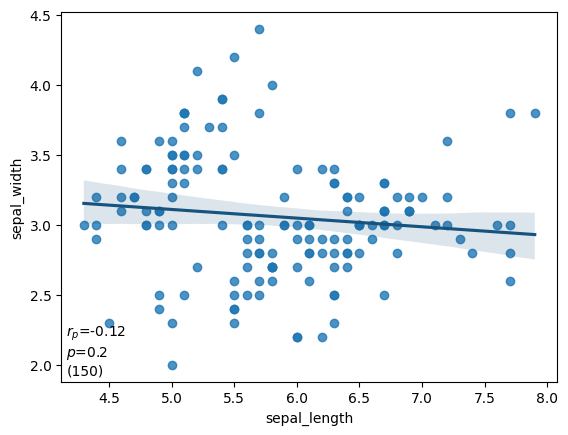

In [14]:
_=(
    data
   .rd.check_corr(
       x='sepal_length',
       y='sepal_width',
       # method='pearson',
       # verbose=True,
       plot=True,
       validate="`r` < 0 & `P` < 0.2"
   ) # validate both no missing values and no duplicates
  )
assert _.compare(data).shape==(0,0), _

### Diff.

INFO:root:mannwhitneyu used
INFO:root:
      variable subset1     subset2    stat             P  mean subset1  median subset1  var subset1  size subset1  mean subset2  median subset2  var subset2  size subset2  difference between mean (subset1-subset2)    change  ratio between mean (subset1-subset2)  difference between median (subset1-subset2)  ratio between median (subset1-subset2)
0  sepal_width  setosa  versicolor  2312.0  2.143380e-13         3.428             3.4      0.14369            50         2.770             2.8     0.098469            50                                      0.658  increase                              1.237545                                          0.6                                1.214286
1  sepal_width  setosa   virginica  2086.0  7.099709e-09         3.428             3.4      0.14369            50         2.974             3.0     0.104004            50                                      0.454  increase                              1.152656      

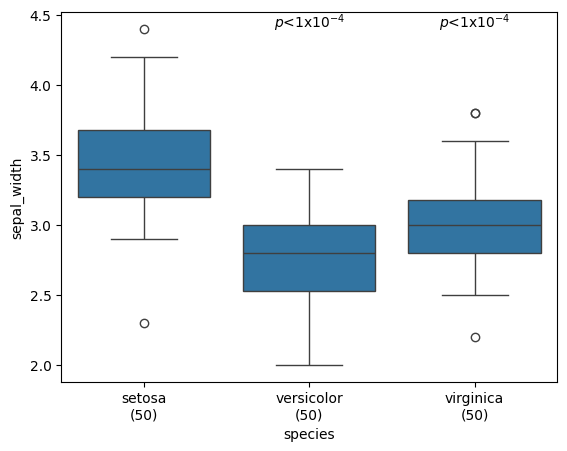

In [15]:
# TODO
_=(
    data
   .assign(id=lambda df: range(len(df)))
   .rd.check_diff(
       x='species',
       y='sepal_width',
       cols_id='id',
       # method='pearson',
       # verbose=True,
       plot=True,
       validate="`P` < 0.05"
   ) # validate both no missing values and no duplicates
  )
assert _.drop(['id'],axis=1).compare(data).shape==(0,0), _

## Logging
### Changes in the dataframe shapes

In [16]:
_=data.log.drop_duplicates()

.. in chained operations

In [17]:
_=(data
   .log.drop_duplicates() # logs the change in the shape of the dataframe (e.g. length)
   .log('sepal_length') # counts of unique values
   .log('sepal_length',groupby='species') # .. grouped by a column/s
   .log(groupby='species') # .. grouped by a column/s
  )

INFO:root:shape = (150, 7) nunique: sepal_length = 35 
INFO:root:shape = (150, 7) by "species", nunique "sepal_length": versicolor = 21; virginica = 21; setosa = 15 
INFO:root:shape = (150, 7) by 'species': setosa = 50; versicolor = 50; virginica = 50 


## Infer
### Index

In [18]:
cols_id=data.rd.infer_index()
cols_id

['species id', 'species']

In [19]:
## test if ids are unique
_=data.rd.assert_no_dups(cols_id)

## Transform  
### Bin (`pd.cut`) 

In [20]:
(data
    .rd.get_bins(col='sepal_length',bins=[0,10,200])
    .rd.get_bins(col='petal_length',bins=[0,10,200])
).head(1)

,sepal_length,sepal_width,petal_length,petal_width,species,sepal_length with missing values,species id,sepal_length bin,petal_length bin
0,5.1,3.5,1.4,0.2,setosa,NaN,item00,$\leq$10,$\leq$10


## Filtering/Subsetting

### Queries with logging

In [21]:
data.rd.query(
    ## caught
    # expr="`species`.str.endswith('a') | `na1` == 0 & `sepal_length` > 5 & `na2` >= 1000 & `sepal_width` <= 3 & ~(`petal_length` < 6)",
    # expr="`species`.str.endswith('a') and `na1` == 0 & `sepal_length` > 5 & `na2` >= 1000 & `sepal_width` <= 3 & ~(`petal_length` < 6)",
    
    expr="`species`.str.endswith('a') & `na1` == 0 & `sepal_length` > 5 & `na2` >= 1000 & `sepal_width` <= 3 & ~(`petal_length` < 6)",
    
    errors=None,
    
    subset='species id', # nunique
    groupby='species',
)

INFO:root:shape = (150, 7) (init)
INFO:root:shape = (100, 7) by "species", nunique "species id": setosa = 50; virginica = 50 (`species`.str.endswith('a'))
INFO:root:shape = (71, 7) by "species", nunique "species id": virginica = 49; setosa = 22 (`sepal_length` > 5)
INFO:root:shape = (32, 7) by "species", nunique "species id": virginica = 32 (`sepal_width` <= 3)
INFO:root:shape = (6, 7) by "species", nunique "species id": virginica = 6 (~(`petal_length` < 6))


,sepal_length,sepal_width,petal_length,petal_width,species,sepal_length with missing values,species id
105,7.6,3.0,6.6,2.1,virginica,NaN,item05
107,7.3,2.9,6.3,1.8,virginica,NaN,item07
118,7.7,2.6,6.9,2.3,virginica,NaN,item18
122,7.7,2.8,6.7,2.0,virginica,NaN,item22
130,7.4,2.8,6.1,1.9,virginica,NaN,item30
135,7.7,3.0,6.1,2.3,virginica,NaN,item35


### Chunking

In [22]:
## chunk of (max.) size
data.rd.get_chunks(
    size=3,
).head(1)

INFO:root:shape = (150, 8) nunique: chunk = 50 


,sepal_length,sepal_width,petal_length,petal_width,species,sepal_length with missing values,species id,chunk
0,5.1,3.5,1.4,0.2,setosa,NaN,item00,0


In [23]:
## n chunks
data.rd.get_chunks(
    n=4,    
).head(1)

INFO:root:shape = (150, 8) nunique: chunk = 4 


,sepal_length,sepal_width,petal_length,petal_width,species,sepal_length with missing values,species id,chunk
0,5.1,3.5,1.4,0.2,setosa,NaN,item00,0


### Filter using a DataFrame

In [24]:
df0_ = pd.DataFrame(
    {
        'cell': ['cell1', 'cell2', 'cell1', 'cell3', 'cell1', 'cell4', 'cell5', 'cell2', 'cell2'],
        'organ': ['organ1', 'organ2', 'organ2', 'organ1', 'organ4', 'organ4', 'organ3', 'organ1', 'organ3'],
        'patient': ['patient1', 'patient1', 'patient1', 'patient1', 'patient2', 'patient2', 'patient3', 'patient2', 'patient2'],
        # 'value': np.random.rand(8)
    }
)
df0_

,cell,organ,patient
0,cell1,organ1,patient1
1,cell2,organ2,patient1
2,cell1,organ2,patient1
3,cell3,organ1,patient1
4,cell1,organ4,patient2
5,cell4,organ4,patient2
6,cell5,organ3,patient3
7,cell2,organ1,patient2
8,cell2,organ3,patient2


In [25]:
df0_rules = pd.DataFrame({
    'cell': ['cell1', np.nan, 'cell1', 'cell2', 'cell3', np.nan, np.nan,'unrelated'],
    'organ': ['organ1', 'organ2', np.nan, 'organ3', np.nan, 'organ4', np.nan, np.nan],
    'patient': ['patient1', 'patient1', 'patient2', np.nan, np.nan, np.nan, 'patient3', np.nan]
})
df0_rules

,cell,organ,patient
0,cell1,organ1,patient1
1,NaN,organ2,patient1
2,cell1,NaN,patient2
3,cell2,organ3,NaN
4,cell3,NaN,NaN
5,NaN,organ4,NaN
6,NaN,NaN,patient3
7,unrelated,NaN,NaN


In [26]:
# %run ../roux/lib/df.py
df_=df0_.rd.filter_rows(
    df0_rules,
)

df_fast=df0_.rd.filter_rows(
    df0_rules,
    fast=True,
)
assert df_.compare(df_fast).empty

assert len(df_)==8, df_
df_

INFO:root:shape = (9, 3) 
INFO:root:shape = (8, 3) 
INFO:root:shape = (9, 3) 
INFO:root:shape = (8, 3) 


,cell,organ,patient
0,cell1,organ1,patient1
1,cell2,organ2,patient1
2,cell1,organ2,patient1
3,cell3,organ1,patient1
4,cell1,organ4,patient2
5,cell4,organ4,patient2
6,cell5,organ3,patient3
8,cell2,organ3,patient2


In [27]:
df_=df0_.rd.filter_rows(df0_rules.iloc[:2,:2])
assert len(df_)==3, df_
df_

INFO:root:shape = (9, 3) 
INFO:root:shape = (3, 3) 


,cell,organ,patient
0,cell1,organ1,patient1
1,cell2,organ2,patient1
2,cell1,organ2,patient1


In [28]:
## reverse
df_=df0_.rd.filter_rows(
    df0_rules,
    mode='drop',
)

df_fast=df0_.rd.filter_rows(
    df0_rules,
    mode='drop',
    fast=True,
)
assert df_.compare(df_fast).empty

assert len(df_)==1, df_
df_

INFO:root:shape = (9, 3) 
INFO:root:shape = (1, 3) 
INFO:root:shape = (9, 3) 
INFO:root:shape = (1, 3) 


,cell,organ,patient
7,cell2,organ1,patient2


In [29]:
df_=df0_.rd.filter_rows(df0_rules.iloc[:2,:2],mode='drop')
assert len(df_)==6, df_
df_

INFO:root:shape = (9, 3) 
INFO:root:shape = (6, 3) 


,cell,organ,patient
3,cell3,organ1,patient1
4,cell1,organ4,patient2
5,cell4,organ4,patient2
6,cell5,organ3,patient3
7,cell2,organ1,patient2
8,cell2,organ3,patient2


### Filter using a dictionary

In [30]:
out=data.rd.filter_rows({'species':'setosa'})
out.head(1)

INFO:root:(150, 7)
INFO:root:(50, 7)


,sepal_length,sepal_width,petal_length,petal_width,species,sepal_length with missing values,species id
0,5.1,3.5,1.4,0.2,setosa,NaN,item00


In [31]:
# for testing
assert out.shape==(50, 7), out.shape

### Triangle of adj. mat.

In [32]:
# import pandas as pd
(
    pd.DataFrame({'a':[1,.5,.3],'b':[.5,1,.4],'c':[.3,.4,1]},index=list('abc'))
    .rd.tri(k=-1)
)

,a,b,c
a,NaN,NaN,NaN
b,0.5,NaN,NaN
c,0.3,0.4,NaN


## Groupby

### Sample

In [33]:
data.rd.groupby_sample('species').shape ## sample a group

INFO:root:sampled group name: setosa


(50, 7)

### Aggregate nested groups

In [34]:
## demo data
data2=(data
    .melt(id_vars=['species'],value_vars=["sepal_length","sepal_width","petal_length","petal_width"],var_name='part measurement')
    .assign(
        part=lambda df: df['part measurement'].str.split('_',expand=True)[0],
        measurement=lambda df: df['part measurement'].str.split('_',expand=True)[1],
    )
    )
data2.head(1)

,species,part measurement,value,part,measurement
0,setosa,sepal_length,5.1,sepal,length


In [35]:
## aggregate
data2.rd.groupby_agg_nested(
    groupby=['species'], # groupby columns
    subset=["part measurement","part","measurement"], ## columns with nested groups
    func={"value": np.mean}, ## column with values and agg function to apply
    )

INFO:root:shape = (600, 5) nunique: part measurement = 4; part = 2; measurement = 2 
/home/rdandage/Documents/work/roux/roux/lib/df.py:1790: FutureWarning: The provided callable <function mean at 0x7c62242d6320> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df2.groupby(cols_groupby)
INFO:root:shape = (12, 5) after a round of aggregation.
/home/rdandage/Documents/work/roux/roux/lib/df.py:1790: FutureWarning: The provided callable <function mean at 0x7c62242d6320> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df2.groupby(cols_groupby)
INFO:root:shape = (6, 3) after a round of aggregation.
/home/rdandage/Documents/work/roux/roux/lib/df.py:1790: FutureWarning: The provided callable <function mean at 0x7c62242d6320> is currently using Seri

,species,value
0,setosa,2.5355
1,versicolor,3.5730
2,virginica,4.2850


### Aggregate ranges

In [36]:
# import pandas as pd
pd.DataFrame(
    dict(
        start=[0,2,5,7,8,10,11],
        values=[0,2,5,7,8,10,11],
    )
).rd.to_ranges(
    colindex='start',
    agg={
        f"values sum": ('values','sum'),
    }
)

INFO:root:setting consecutive values as ranges ..


,start min,start max,values sum
0,0,0,0
1,2,2,2
2,5,5,5
3,7,8,15
4,10,11,21


## Merge

**Demo data**

In [37]:
data2=data.groupby('species').head(1)

### Validation of changes in table shapes

In [38]:
out=data.log.merge( # logs the changes in the shapes of the dataframe
    right=data2,
    how='inner',
    on='species',
    validate='m:1',
    validate_equal_length=True,
    # validate_no_decrease_length=True,
    )
out.head(1)

INFO:root:merge: shape changed: (150, 7)->(150, 13), length constant


,sepal_length_x,sepal_width_x,petal_length_x,petal_width_x,species,sepal_length with missing values_x,species id_x,sepal_length_y,sepal_width_y,petal_length_y,petal_width_y,sepal_length with missing values_y,species id_y
0,5.1,3.5,1.4,0.2,setosa,NaN,item00,5.1,3.5,1.4,0.2,NaN,item00


In [39]:
# for testing
assert out.shape==(150, 13), out.shape

## Melt

**Demo data with paired IDs and values**

In [40]:
np.random.seed(1)
data=(
    data
    .assign(
    **{
        ## create paired ids
        "id 1":lambda df: range(len(df)),
        "id 2":lambda df: range(len(df))[::-1],
    }
    )
    .rename(
        columns={
            "sepal_length": "value 1",
            "sepal_width": "value 2",
            
        },
        errors='raise',
    )
    .loc[:,['id 1','id 2','value 1','value 2']]
).sample(5).reset_index(drop=True)
## example order
order=list(set(data['id 1'].tolist()+data['id 2'].tolist()))
order=list(np.random.choice(order,len(order),replace=False))
data

,id 1,id 2,value 1,value 2
0,14,135,5.8,4.0
1,98,51,5.1,2.5
2,75,74,6.6,3.0
3,16,133,5.4,3.9
4,131,18,7.9,3.8


In [41]:
# for testing
assert data.shape==(5,4), data.shape

### Tables with paired IDs

In [42]:
out=data.rd.melt_paired(suffixes=['1','2'])
out

,suffix,id,value
0,1,14,5.8
1,1,98,5.1
2,1,75,6.6
3,1,16,5.4
4,1,131,7.9
0,2,135,4.0
1,2,51,2.5
2,2,74,3.0
3,2,133,3.9
4,2,18,3.8


In [43]:
# for testing
assert out.shape==(10,3), out.shape

## Sort 

### Paired columns by values

In [44]:
out=data.rd.sort_columns_by_values(['id 1','id 2'])
out

INFO:root:suffixes inferred: ['1', '2']
INFO:root:(equal, sorted) items: {(False, False): 2, (False, True): 3}


,equal,sorted,id 1,id 2,value 1,value 2
0,False,False,14,135,5.8,4.0
3,False,False,16,133,5.4,3.9
1,False,True,51,98,2.5,5.1
2,False,True,74,75,3.0,6.6
4,False,True,18,131,3.8,7.9


In [45]:
# for testing
assert out['id 1'].tolist()==[14, 16, 51, 74, 18], out['id 1'].tolist()

### Paired columns by order

In [46]:
order

[np.int64(133),
 np.int64(135),
 np.int64(14),
 np.int64(51),
 np.int64(131),
 np.int64(18),
 np.int64(75),
 np.int64(16),
 np.int64(98),
 np.int64(74)]

In [47]:
out=data.rd.sort_columns_by_values(
    ['id 1','id 2'],
    order=order, # order of the ids
    clean=True,
)
out

INFO:root:suffixes inferred: ['1', '2']
INFO:root:(equal, sorted) items: {(False, False): 2, (False, True): 3}


,id 1,id 2,value 1,value 2
2,75,74,6.6,3.0
4,131,18,7.9,3.8
0,135,14,4.0,5.8
1,51,98,2.5,5.1
3,133,16,3.9,5.4


In [48]:
# for testing
assert out['id 1'].tolist()==[75, 131, 135, 51, 133], out['id 1'].tolist()

## Mapping between columns

**Demo data**

In [49]:
data=(
    data
    .loc[:,['id 1']].head(10)
    .assign(
    **{
        ## create shuffled ids
        "id 2":lambda df: np.random.choice(df['id 1'],len(df)),
    }
    )
)
data

,id 1,id 2
0,14,16
1,98,98
2,75,98
3,16,131
4,131,131


### Classify

In [50]:
out=data.rd.classify_mappings(subset=['id 1','id 2'])
out

,id 1,id 2,id 1 count,id 2 count,mapping
0,14,16,1,1,1:1
1,98,98,2,1,m:1
2,75,98,2,1,m:1
3,16,131,2,1,m:1
4,131,131,2,1,m:1


In [51]:
# for testing
assert out['mapping'].tolist()==['1:1', 'm:1', 'm:1', 'm:1', 'm:1'], out['mapping'].tolist()

### Check counts

In [52]:
out=data.rd.check_mappings(subset=['id 1','id 2'])
out

,,,mappings count
mapping,id 1 count,id 2 count,
1:1,1,1,1
m:1,2,1,4


In [53]:
# for testing
assert out['mappings count'].tolist()==[1, 4], out['mappings count'].tolist()

### Filter

In [54]:
out=data.rd.get_mappings(
    subset=['id 1','id 2'],
    keep="2:1", # keep 3:1 mappings
    clean=False,
)
out

INFO:root:query: shape changed: (5, 5)->(4, 5), width constant


,id 1,id 2,id 1 count,id 2 count,mapping
1,98,98,2,1,m:1
2,75,98,2,1,m:1
3,16,131,2,1,m:1
4,131,131,2,1,m:1


In [55]:
# for testing
assert out.shape==(4,5), out

In [56]:
out=data.rd.get_mappings(
    subset=['id 1','id 2'],
    keep='1:1', ## keep 1:1 mappings
    clean=True,
    )
out

INFO:root:query: shape changed: (5, 3)->(1, 3), width constant


,id 1,id 2,mapping
0,14,16,1:1


In [57]:
# for testing
assert out['mapping'].tolist()==['1:1'], out['mapping'].tolist()

### Validate

In [58]:
data.rd.classify_mappings(subset=['id 1','id 2'])

,id 1,id 2,id 1 count,id 2 count,mapping
0,14,16,1,1,1:1
1,98,98,2,1,m:1
2,75,98,2,1,m:1
3,16,131,2,1,m:1
4,131,131,2,1,m:1


In [59]:
# for testing
assert len(data)==5

In [60]:
data.head(1).rd.assert_1_1_mappings(subset=['id 1','id 2'])

,id 1,id 2
0,14,16


## Plot

In [61]:
# data.rd.plot

## Documentation
[`roux.lib.df`](https://github.com/rraadd88/roux#module-rouxlibdf)